In [1]:
%matplotlib inline
import numpy as np
import os,random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
TRAIN_PATH="DATA/chest_xray/train/"
VAL_PATH="DATA/chest_xray/val/"
TEST_PATH="DATA/chest_xray/test/"


2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
for img_class in os.listdir(TRAIN_PATH):
    print(str(len(os.listdir(TRAIN_PATH + img_class ))) + " " + img_class + " train images")

for img_class in os.listdir(VAL_PATH):
    print(str(len(os.listdir(VAL_PATH + img_class ))) + " " + img_class + " val images")

for img_class in os.listdir(TEST_PATH):
    print(str(len(os.listdir(TEST_PATH + img_class ))) + " " + img_class + " test images")

1207 NORMAL train images
3488 PNEUMONIA train images
142 NORMAL val images
395 PNEUMONIA val images
234 NORMAL test images
390 PNEUMONIA test images


NORMAL2-IM-1279-0001.jpeg (1476, 1956)


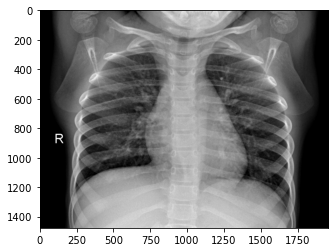

In [3]:
np.random.seed(42)
normal_image=np.random.choice(os.listdir(TRAIN_PATH+"NORMAL/"))
im=img.imread(TRAIN_PATH+"NORMAL/"+normal_image)
print(normal_image,im.shape)
plt.imshow(im,cmap='gray')
plt.show()

person578_bacteria_2379.jpeg (763, 1068)


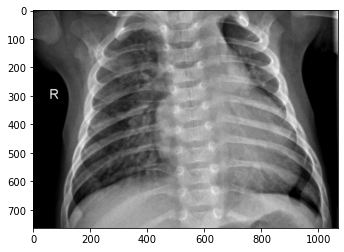

In [4]:
np.random.seed(76)
p_image=np.random.choice(os.listdir(TRAIN_PATH+"PNEUMONIA/"))
im=img.imread(TRAIN_PATH+"PNEUMONIA/"+p_image)
print(p_image,im.shape)
plt.imshow(im,cmap='gray')
plt.show()

In [5]:
input_shape=(64,64)
batch_size=32

train_gen=ImageDataGenerator( rescale = 1./255,shear_range=0.3,
                             zoom_range=0.3,horizontal_flip=True )

train_data=train_gen.flow_from_directory( TRAIN_PATH,
                                             target_size=input_shape,
                                             batch_size=batch_size,
                                             color_mode='grayscale',
                                             class_mode='categorical',
                                             shuffle=True,
                                             seed=42 )


Found 4695 images belonging to 2 classes.


In [6]:
val_gen=ImageDataGenerator( rescale=1./255 )

val_data=val_gen.flow_from_directory( VAL_PATH,
                                             target_size=input_shape,
                                             batch_size=batch_size,
                                             color_mode='grayscale',
                                             class_mode='categorical')

Found 537 images belonging to 2 classes.


In [7]:
test_gen=ImageDataGenerator( rescale=1./255 )

test_data=test_gen.flow_from_directory( TEST_PATH,
                                      target_size=input_shape,
                                      batch_size=batch_size,
                                      color_mode='grayscale',
                                      class_mode='categorical')


Found 624 images belonging to 2 classes.


In [8]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import Accuracy,Precision,Recall
from livelossplot import PlotLossesKerasTF

In [9]:
model1=Sequential([
    
    Conv2D(32,(3,3),input_shape=(64,64,1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64,(3,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(128,(3,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(2),
    Activation('softmax')
])

In [10]:
opt=SGD(learning_rate=0.01,momentum=0.9)
model1.compile(optimizer= opt,loss='categorical_crossentropy',metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 29, 29, 64)        0

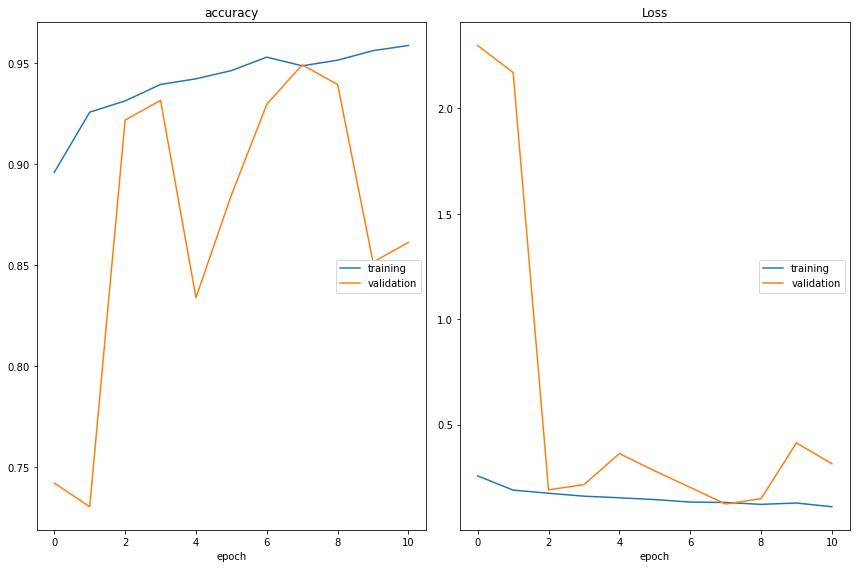

accuracy
	training         	 (min:    0.896, max:    0.959, cur:    0.959)
	validation       	 (min:    0.730, max:    0.949, cur:    0.861)
Loss
	training         	 (min:    0.110, max:    0.256, cur:    0.110)
	validation       	 (min:    0.123, max:    2.299, cur:    0.314)
146/146 [==============================] - 55s 374ms/step - loss: 0.1100 - accuracy: 0.9588 - val_loss: 0.3141 - val_accuracy: 0.8613
Epoch 12/15
  8/146 [>.............................] - ETA: 38s - loss: 0.0956 - accuracy: 0.9609

KeyboardInterrupt: 

In [11]:
epochs = 15
steps_per_epoch = train_data.n//train_data.batch_size
validation_steps = val_data.n//val_data.batch_size

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2, min_lr=0.00001, mode='auto')
#checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             #save_weights_only=True, mode='max', verbose=1)
plotlosses = PlotLossesKerasTF()

history = model1.fit(
    x=train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = val_data,
    validation_steps = validation_steps,
    callbacks=[plotlosses]
)

In [ ]:
model1.evaluate(val_data)

In [ ]:
model1.save_weights("model1.h5")

In [ ]:
count_N=len(os.listdir(TRAIN_PATH + "NORMAL/" ))
count_P=len(os.listdir(TRAIN_PATH + "PNEUMONIA/" ))
Total=count_N+count_P
N=Total/(count_N*2.0)
P=Total/(count_P*2.0)
class_weights={0:N,1:P }
class_weights

In [ ]:
model2=Sequential([
    
    Conv2D(32,(3,3),input_shape=(64,64,1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64,(3,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(128,(3,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(256,(3,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(2),
    Activation('softmax')
])

In [ ]:
model2.summary()

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,EarlyStopping

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)


In [ ]:
opt=Adam(learning_rate=0.01)
model2.compile(optimizer= opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
epochs = 50
steps_per_epoch = train_data.n//train_data.batch_size
validation_steps = val_data.n//val_data.batch_size

LR_Scheduler=LearningRateScheduler(exponential_decay_fn)
checkpoint = ModelCheckpoint("final_model_weights.h5", monitor='val_accuracy',save_best_only=True,
                             save_weights_only=True, mode='max')

earlystopping=EarlyStopping(patience=5,restore_best_weights=True)
plotlosses = PlotLossesKerasTF()

history = model2.fit(
    x=train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = val_data,
    validation_steps = validation_steps,
    class_weight=class_weights,
    callbacks=[plotlosses,earlystopping,checkpoint,LR_Scheduler]
)